In [1]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras import Model
import time

In [2]:
from cvae import CVAE, optimizer, log_normal_pdf, compute_loss, train_step

## MNIST dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

x_train = preprocess_images(x_train)
x_test = preprocess_images(x_test)

In [5]:
train_size = x_train.shape[0] # = 60000
batch_size = 32
test_size = x_test.shape[0] # = 10000
label_size = 10

In [6]:
train_dataset_x = tf.data.Dataset.from_tensor_slices(x_train)
test_dataset_x = tf.data.Dataset.from_tensor_slices(x_test)
print(train_dataset_x, test_dataset_x)

<TensorSliceDataset shapes: (28, 28, 1), types: tf.float32> <TensorSliceDataset shapes: (28, 28, 1), types: tf.float32>


In [7]:
train_dataset_y= tf.data.Dataset.from_tensor_slices(y_train)
test_dataset_y = tf.data.Dataset.from_tensor_slices(y_test)
print(train_dataset_y, test_dataset_y)

<TensorSliceDataset shapes: (), types: tf.uint8> <TensorSliceDataset shapes: (), types: tf.uint8>


### make (image, label) pair

In [8]:
train_dataset_xy = tf.data.Dataset.zip((train_dataset_x, train_dataset_y))
train_dataset_xy = train_dataset_xy.shuffle(train_size).batch(batch_size)
test_dataset_xy = tf.data.Dataset.zip((test_dataset_x, test_dataset_y))
test_dataset_xy = test_dataset_xy.shuffle(train_size).batch(batch_size)
print(train_dataset_xy, test_dataset_xy)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)> <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>


## モデル準備

In [9]:
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 64
num_examples_to_generate = 16

In [10]:
model = CVAE(latent_dim, label_size)
print(model.encoder.summary())
print('')
print(model.decoder.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 32)        3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               295040    
Total params: 316,736
Trainable params: 316,736
Non-trainable params: 0
_________________________________________________________________
None

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1568)              117600    
______________________

## 学習

In [11]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(*test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z, test_sample[1])
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [12]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset_xy.take(1):
  test_sample = (test_batch[0][0:num_examples_to_generate, :,  :, :], test_batch[1][0:num_examples_to_generate])

Epoch: 100, Train set ELBO: -70.36550903320312, Test set ELBO: -70.93404388427734, time elapse for current epoch: 4.649653196334839


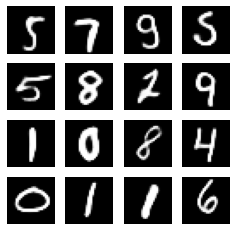

In [13]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train in train_dataset_xy:
    train_step(model, train, optimizer)
  end_time = time.time()

  loss_tr = tf.keras.metrics.Mean()
  for train in train_dataset_xy:
    loss_tr(compute_loss(model, train))
  elbo_tr = -loss_tr.result()

  loss_tst = tf.keras.metrics.Mean()
  for test in test_dataset_xy:
    loss_tst(compute_loss(model, test))
  elbo_tst = -loss_tst.result()
  display.clear_output(wait=False)
  print(f'Epoch: {epoch}, Train set ELBO: {elbo_tr}, Test set ELBO: {elbo_tst}, time elapse for current epoch: {end_time - start_time}')
  generate_and_save_images(model, epoch, test_sample)

## 復元

In [14]:
def show_pics(pics):
  fig = plt.figure(figsize=(8, 4))
  for i in range(pics.shape[0]):
    plt.subplot(4, 8, i + 1)
    plt.imshow(pics[i, :, :, 0], cmap='gray')
    plt.axis('off')

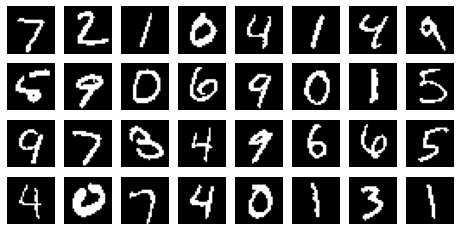

In [15]:
show_pics(x_test[0:32])

In [16]:
mean, logvar = model.encode(x_test[0:32], y_test[0:32])
z = model.reparameterize(mean, logvar)

### ラベルそのまま

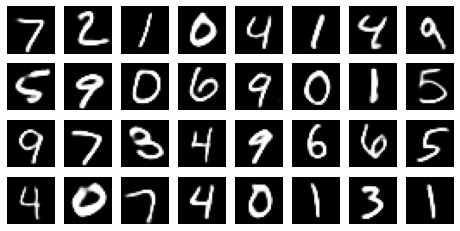

In [17]:
show_pics(model.sample(z, y_test[0:32]))

### ラベル統一

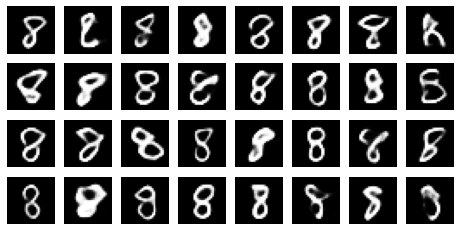

In [18]:
show_pics(model.sample(z, np.ones(32, dtype='uint8')*8))

## 連続変化

In [19]:
def continuous_gen(model, fst_ind, snd_ind, label, w, h):
    continuous = []
    n = w * h
    for i in range(n):
        middle_z = tf.add(tf.scalar_mul(float(n-i)/n, z[fst_ind]), tf.scalar_mul(float(i)/n, z[snd_ind]))
        continuous.append(model.sample(tf.reshape(middle_z, [1, latent_dim]), [label]))

    fig = plt.figure(figsize=(w, h))
    for i in range(n):
        plt.subplot(h, w, i + 1)
        plt.imshow(tf.reshape(continuous[i], [28, 28]), cmap='gray')
        plt.axis('off')

### 太い線から細い線へ連続変化

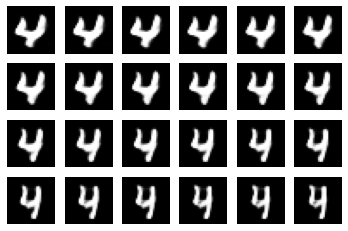

In [20]:
continuous_gen(model, 25, 28, 4, 6, 4)

### 傾きの連続変化

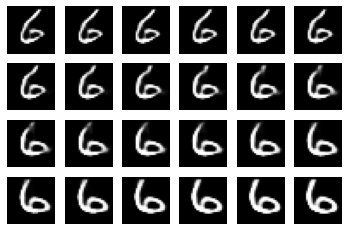

In [22]:
continuous_gen(model, 2, 18, 6, 6, 4)